In [1]:
import collections

import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.collections
import tqdm
import IPython
import ipywidgets


%matplotlib inline

In [2]:
# this notebook shows how to generate grid enclosures for the case where you only have cell centres for a curvilinear grid


ds = netCDF4.Dataset('/Users/baart_f/data/matroos/201606211200.nc')


In [3]:
# take a subset
s = np.s_[150:160, 960:970]
s = np.s_[200:300, 900:1000]
s = np.s_[:, :]
lat_orig = ds.variables['lat'][s]
lon_orig = ds.variables['lon'][s]

# make copies so we can edit in place
# we edit lat, lon by adding ghost cells
lat = lat_orig.copy()
lon = lon_orig.copy()


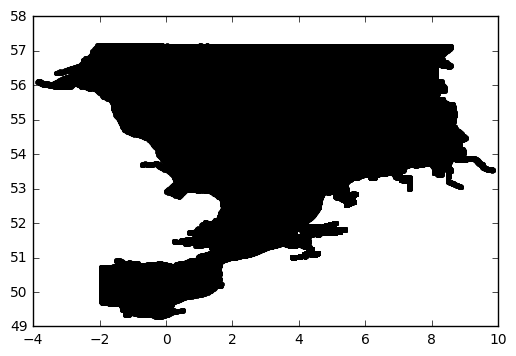

In [4]:
fig, ax = plt.subplots()
ax.plot(lon_orig.flatten(), lat_orig.flatten(), 'k.')


In [5]:
# We create ghost cells by computing boolean differences from different directions

# cells are on an edge if there is a change in mask difference from a direction
right = np.logical_and(lat[:,:-1].mask, np.diff(lat.mask, axis=1))
left = np.logical_and(lat[:,1:].mask, np.diff(lat.mask, axis=1))
left_right = np.logical_and(left, right)
top = np.logical_and(lat[1:,:].mask, np.diff(lat.mask, axis=0))
bottom = np.logical_and(lat[:-1,:].mask, np.diff(lat.mask, axis=0))
top_bottom = np.logical_and(top, bottom)


In [6]:
col_0 = np.zeros((lat.shape[0], 1), dtype='bool')
row_0 = np.zeros((1, lat.shape[1]), dtype='bool')

# column mask is not right column mask and right column is not masked
right = (lat.mask[:, 1:] != lat.mask[:, :-1]) & ~lat.mask[:, 1:]
# extend right
right = np.c_[right, col_0]

left = (lat.mask[:, :-1] != lat.mask[:, 1:]) & ~lat.mask[:, :-1]
# extend left
left = np.c_[col_0, left]
# single colums (don't fill these up)
# assert not (left & right).any(), "single columns"

# column mask is not right column mask and right column is not masked
top = (lat.mask[:-1, :] != lat.mask[1:, :] ) & ~lat.mask[:-1, :]
# extend top
top = np.r_[row_0, top]


# column mask is not right column mask and right column is not masked
bottom = (lat.mask[1:, :] != lat.mask[:-1, :]) & ~lat.mask[1:, :]
bottom.shape
# extend right
bottom = np.r_[bottom, row_0]
# assert not (bottom & top).any(), "single rows"



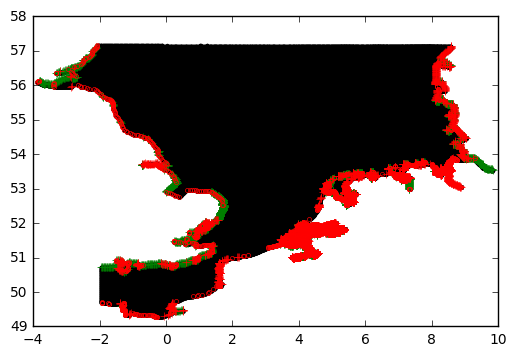

In [7]:
fig, ax = plt.subplots()
ax.plot(lon_orig.flatten(), lat_orig.flatten(), 'k.', markersize=4)
i,j = np.where(bottom)
ax.plot(lon_orig[i+1, j], lat_orig[i+1, j], 'k.', markerfacecolor='none')
i,j = np.where(top)
ax.plot(lon_orig[i-1, j], lat_orig[i-1, j], 'g+', markerfacecolor='none')
i,j = np.where(left)
ax.plot(lon_orig[i, j-1], lat_orig[i, j-1], 'r.', markerfacecolor='none')
i,j = np.where(right)
ax.plot(lon_orig[i, j+1], lat_orig[i, j+1], 'r+', markerfacecolor='none')


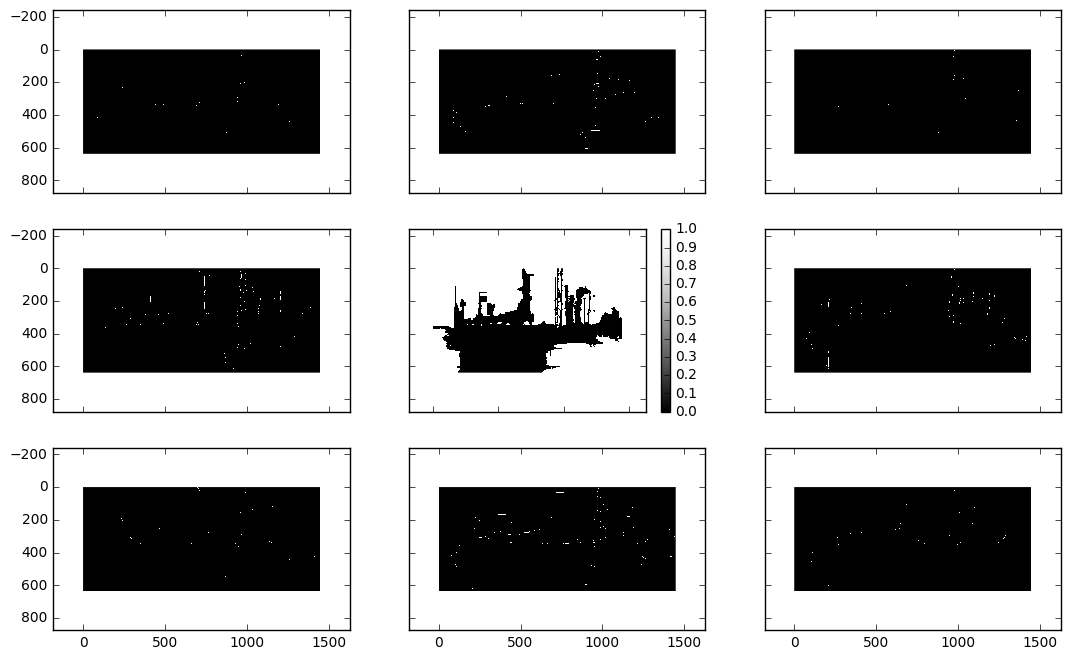

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(13, 8), sharex=True, sharey=True)

                       
# change from right
axes[1, 2].imshow(right, cmap='Greys_r', interpolation='none')
# changes from left
axes[1, 0].imshow(left, cmap='Greys_r', interpolation='none')

# changes from top
axes[0, 1].imshow(top, cmap='Greys_r', interpolation='none')
# changes from bottom
axes[2, 1].imshow(bottom, cmap='Greys_r', interpolation='none')

# changes from top left
axes[0, 0].imshow(top & left, cmap='Greys_r', interpolation='none')
# changes from top right
axes[0, 2].imshow(top & right, cmap='Greys_r', interpolation='none')
# changes from bottom left
axes[2, 0].imshow(bottom & left, cmap='Greys_r', interpolation='none')
# changes from bottom right
axes[2, 2].imshow(bottom & right, cmap='Greys_r', interpolation='none')


# changes left and right
im = axes[1, 1].imshow(lat[:,:].mask, cmap='Greys_r', interpolation='none')
plt.colorbar(im, ax=axes[1,1])

# axes[1, 2].imshow(np.logical_and(lat[1:,1:].mask, np.diff(lat.mask, axis=0)), cmap='Greys_r', interpolation='none')
# np.diff(lat, axis=1)


In [9]:
# fill from top
i, j = np.where(top)
not_edge = i > 1
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i-1,j] + (lat[i-1, j] - lat[i-2, j]) 
lon[i, j] = lon[i-1,j] + (lon[i-1, j] - lon[i-2, j]) 

# fill from bottom
i, j = np.where(bottom)
not_edge = (i + 1) < lat.shape[0]
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i+1,j] + (lat[i+1, j] - lat[i+2, j]) 
lon[i, j] = lon[i+1,j] + (lon[i+1, j] - lon[i+2, j]) 

# fill from left
i, j = np.where(left)
not_edge = j > 1
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i,j-1] + (lat[i, j-1] - lat[i, j-2]) 
lon[i, j] = lon[i,j-1] + (lon[i, j-1] - lon[i, j-2]) 

# fill from right
i, j = np.where(right)
not_edge = (j + 1) < lat.shape[1]
i = i[not_edge]
j = j[not_edge]
lat[i, j] = lat[i,j+1] + (lat[i, j+1] - lat[i, j+2]) 
lon[i, j] = lon[i,j+1] + (lon[i, j+1] - lon[i, j+2]) 

# left and right
i, j = np.where(left & right)
not_edge = ((j + 1) < lat.shape[1]) & (j > 1)
i = i[not_edge]
j = j[not_edge]
lat[i, j] = (
    lat[i,j-1] + (lat[i, j-1] - lat[i, j-2]) + 
    lat[i,j+1] + (lat[i, j+1] - lat[i, j+2])
) / 2.0
lon[i, j] = (
    lon[i,j-1] + (lon[i, j-1] - lon[i, j-2]) +
    lon[i,j+1] + (lon[i, j+1] - lon[i, j+2])
) / 2.0

i, j = np.where(top & bottom)
not_edge = (i > 1) & (i + 1) < lat.shape[0]
i = i[not_edge]
j = j[not_edge]
lat[i, j] = (
    lat[i-1,j] + (lat[i-1, j] - lat[i-2, j]) +
    lat[i+1,j] + (lat[i+1, j] - lat[i+2, j]) 
) / 2.0
lon[i, j] = (
    lon[i-1,j] + (lon[i-1, j] - lon[i-2, j]) +
    lon[i+1,j] + (lon[i+1, j] - lon[i+2, j]) 
) / 2.0

In [10]:
lat_bounds = np.ma.zeros(lat.shape + (5,))
lat_bounds.mask = True
lon_bounds = np.ma.zeros(lat.shape + (5,))
lon_bounds.mask = True

# ll
lat_bounds[1:-1, 1:-1, 0] = (lat[1:-1, 1:-1] + lat[:-2, 1:-1] + lat[:-2, :-2] + lat[1:-1, :-2])/4.0
lon_bounds[1:-1, 1:-1, 0] = (lon[1:-1, 1:-1] + lon[:-2, 1:-1] + lon[:-2, :-2] + lon[1:-1, :-2])/4.0

# lr
lat_bounds[1:-1, 1:-1, 1] = (lat[1:-1, 1:-1] + lat[:-2, 1:-1] + lat[:-2, 2:] + lat[1:-1, 2:])/4.0
lon_bounds[1:-1, 1:-1, 1] = (lon[1:-1, 1:-1] + lon[:-2, 1:-1] + lon[:-2, 2:] + lon[1:-1, 2:])/4.0

# ur
lat_bounds[1:-1, 1:-1, 2] = (lat[1:-1, 1:-1] + lat[2:, 1:-1] + lat[2:, 2:] + lat[1:-1, 2:])/4.0
lon_bounds[1:-1, 1:-1, 2] = (lon[1:-1, 1:-1] + lon[2:, 1:-1] + lon[2:, 2:] + lon[1:-1, 2:])/4.0

# ul
lat_bounds[1:-1, 1:-1, 3] = (lat[1:-1, 1:-1] + lat[2:, 1:-1] + lat[2:, :-2] + lat[1:-1, :-2])/4.0
lon_bounds[1:-1, 1:-1, 3] = (lon[1:-1, 1:-1] + lon[2:, 1:-1] + lon[2:, :-2] + lon[1:-1, :-2])/4.0

lat_bounds[1:-1, 1:-1, 4] = lat_bounds[1:-1, 1:-1, 0]  
lon_bounds[1:-1, 1:-1, 4] = lon_bounds[1:-1, 1:-1, 0]  

    

In [11]:
mask = lon_bounds.mask.any(axis=-1)
verts = np.stack([lon_bounds, lat_bounds], axis=-1)
faces = matplotlib.collections.PolyCollection(
    verts=verts[~mask], 
    edgecolor=(0, 0, 0, 0.5), 
    facecolor=(0, 0.5, 0.3, 0.2),
    linewidth=0.3
)

row_or_col = (left & right) | (top & bottom)
multiple = matplotlib.collections.PolyCollection(
    verts=verts[np.logical_and(~mask, row_or_col)], 
    edgecolor=(0, 0, 0, 0.5), 
    facecolor=(0.8, 0.2, 0.2, 0.5),
    linewidth=0.3
)



(51.8, 51.9)

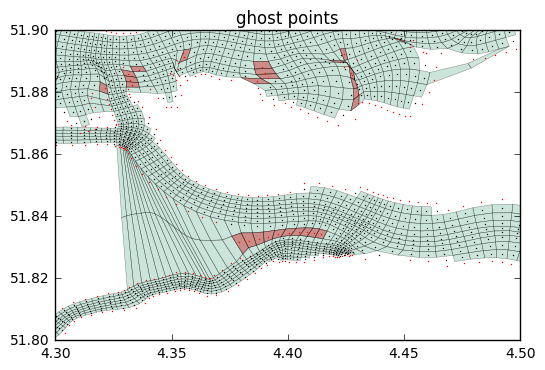

In [12]:
fig, ax = plt.subplots()
ax.set_title('ghost points')
ax.add_collection(faces)
ax.add_collection(multiple)
ax.plot(lon[lon_orig.mask].flatten(), lat[lon_orig.mask].flatten(), 'r.', markersize=1)
ax.plot(lon_orig.flatten(), lat_orig.flatten(), 'k.', markersize=1)
ax.autoscale()
ax.set_xlim(4.3, 4.5)
ax.set_ylim(51.8, 51.9)

In [13]:
faces = []
m, n = lat_orig.shape
for i, j in np.ndindex((m, n)):
    lat_i = np.ma.zeros((3, 3), dtype='double')
    lon_j = np.ma.zeros((3, 3), dtype='double')
    if i == 0:
        # top edge
        pass
    elif i == (m-1):
        # bottom edge
        pass
    else:
        pass
        

    if j == 0:
        # left edge
        pass
    elif j == (n-1):
        # right edge
        pass
    else:
        pass
        


In [14]:
import skimage.util


def view(i, j, arrs):
    m, n = lat.shape
    i_min = max(i-2, 0)
    i_max = min(i+3, m)
    j_min = max(j-2, 0)
    j_max = min(j+3, n)
    s = np.s_[i_min:i_max, j_min:j_max]
    views = []
    for arr in arrs:
        view = arr[s]
        if view.shape == (5, 5):
            views.append(view)
        else:
            i_0 = max(2 - i, 0)
            j_0 = max(2 - j, 0)
            padded_view = np.ma.masked_all((5, 5), dtype=view.dtype)          
            padded_view[i_0:i_0+view.shape[0], j_0:j_0+view.shape[1]] = view
            views.append(padded_view)
    return views
for i,j in tqdm.tqdm_notebook(list(np.ndindex(lat.shape))[:100000]):
    view(i, j, [lat, lon, lat.mask, left, right])

/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:80: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:81: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


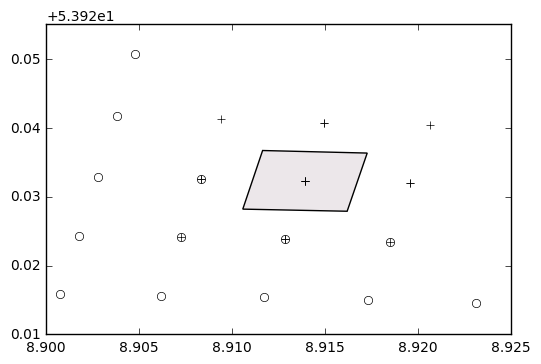

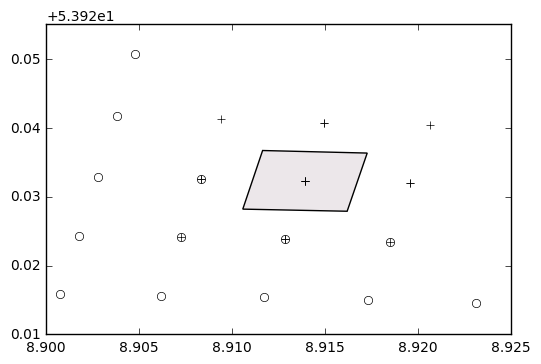

In [23]:
assert np.allclose(lat_orig.mask, lon_orig.mask)
arrs = [lat_orig.copy(), lon_orig.copy()]
fig, ax = plt.subplots()
_ = ax.plot(lon_orig[~lon_orig.mask].flatten(), lat_orig[~lat_orig.mask], 'k.')

# points to fill
# local mid 
def build_points():
    m = 2 
    points = []
    for (i,j) in [
            # + shape
            (m, m),
            (m, m-1),
            (m+1, m),
            (m, m+1),
            (m-1, m),
            (m-1, m-1),
            (m+1, m-1),
            (m-1, m+1),
            (m+1, m+1)
        ]:
        point = {
            "ij": [i, j],
            "interpolates": [
                [[i-1, j], [i+1, j]],
                [[i, j-1], [i, j+1]]
            ],
            "extrapolate": []
        }
        if i >= 2:
            point["extrapolate"].append([[i-1, j], [i-2, j]])
        if i < 3: 
            point["extrapolate"].append([[i+1, j], [i+2, j]])
        if j >= 2:
            point["extrapolate"].append([[i, j-1], [i, j-2]])
        if j < 3:
            point["extrapolate"].append([[i, j+1], [i, j+2]])
        points.append(point)
    return points
points = build_points()

def ij2verts(i_view, j_view):
    views = view(i_view, j_view, arrs)
    lat_i, lon_i = views
    for obj in points:
        i, j = obj['ij']
        if not lat_i.mask[i, j]:
            # should not be masked
            continue
        # filling with obj
        weight = 0
        lat_ij = 0
        lon_ij = 0
        for (i_a, j_a), (i_b, j_b) in obj["interpolates"]:
            # can we interpolate
            if (not lat_i.mask[i_a, j_a]) and (not lat_i.mask[i_b, j_b]):
                lat_ij += lat_i[i_a, j_a]
                lat_ij += lat_i[i_b, j_b]
                lon_ij += lon_i[i_a, j_a]
                lon_ij += lon_i[i_b, j_b]
                weight += 2.0
        if weight > 0:
            # interpolate
            lat_i[i, j] = lat_ij/weight
            lon_i[i, j] = lon_ij/weight
            # this point is filled, on with the next one
            continue
        # if we can't interpolate let's try to extrapolate
        weight = 0
        lat_ij = 0
        lon_ij = 0
        for (i_a, j_a), (i_b, j_b) in obj["extrapolate"]:
            # can we extrapolate
            if (not lat_i.mask[i_a, j_a]) and (not lat_i.mask[i_b, j_b]):
                lon_ij += lon_i[i_a, j_a] + (lon_i[i_a, j_a] - lon_i[i_b, j_b]) 
                lat_ij += lat_i[i_a, j_a] + (lat_i[i_a, j_a] - lat_i[i_b, j_b]) 
                weight += 1
        if weight > 0:
            lat_i[i, j] = lat_ij/weight
            lon_i[i, j] = lon_ij/weight
            # this point is filled, on with the next one
            continue
    m = 2
    
    ll_idx = np.array([[m, m], [m, m-1], [m+1, m-1], [m+1, m]])
    lr_idx = np.array([[m, m], [m+1, m], [m+1, m+1], [m, m+1]])
    ur_idx = np.array([[m, m], [m, m+1], [m-1, m+1], [m-1, m]])
    ul_idx = np.array([[m, m], [m-1, m], [m-1, m-1], [m, m-1]])

    vertices = []
    for idx in (ll_idx, lr_idx, ur_idx, ul_idx):
        s = idx[:,0], idx[:,1]

        vertex = (lon_i[s], lat_i[s])
        if np.ma.is_masked(vertex[0]) or np.ma.is_masked(vertex[1]):
            continue
        vertices.append(vertex) 
    verts = np.array(vertices)
    return verts

def plot(i_view, j_view):
    verts = ij2verts(i_view, j_view)
    lat_i, lon_i = view(i_view, j_view, arrs=arrs)
    # plot
    ax.clear()
    
    ax.fill(verts.mean(axis=-1)[:,0], verts.mean(axis=-1)[:,1], facecolor=(0.3, 0.1, 0.2, 0.1))
    ax.plot(lon_i[~lon_i.mask], lat_i[~lat_i.mask], 'ko', markerfacecolor='none')
    ax.plot(verts[:,0].ravel(), verts[:,1].ravel(), 'k+')
        
    ax.autoscale()
    IPython.display.display(fig)

_ = ipywidgets.interact(
    plot, 
    i_view=ipywidgets.IntSlider(min=0,max=lat.shape[0],step=1,value=378), 
    j_view=ipywidgets.IntSlider(min=0,max=lon.shape[0],step=1,value=100)
)         

In [24]:
vertices = {}
for i, j in tqdm.tqdm_notebook(list(np.ndindex(lat_orig.shape))):
    verts = ij2verts(i, j)
    if len(verts) and verts.shape == (4, 2, 4):
        vertices[(i, j)] = verts.mean(axis=-1)


/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:80: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:81: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py:65: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/ipykernel/__main__.py

(52.8, 53.5)

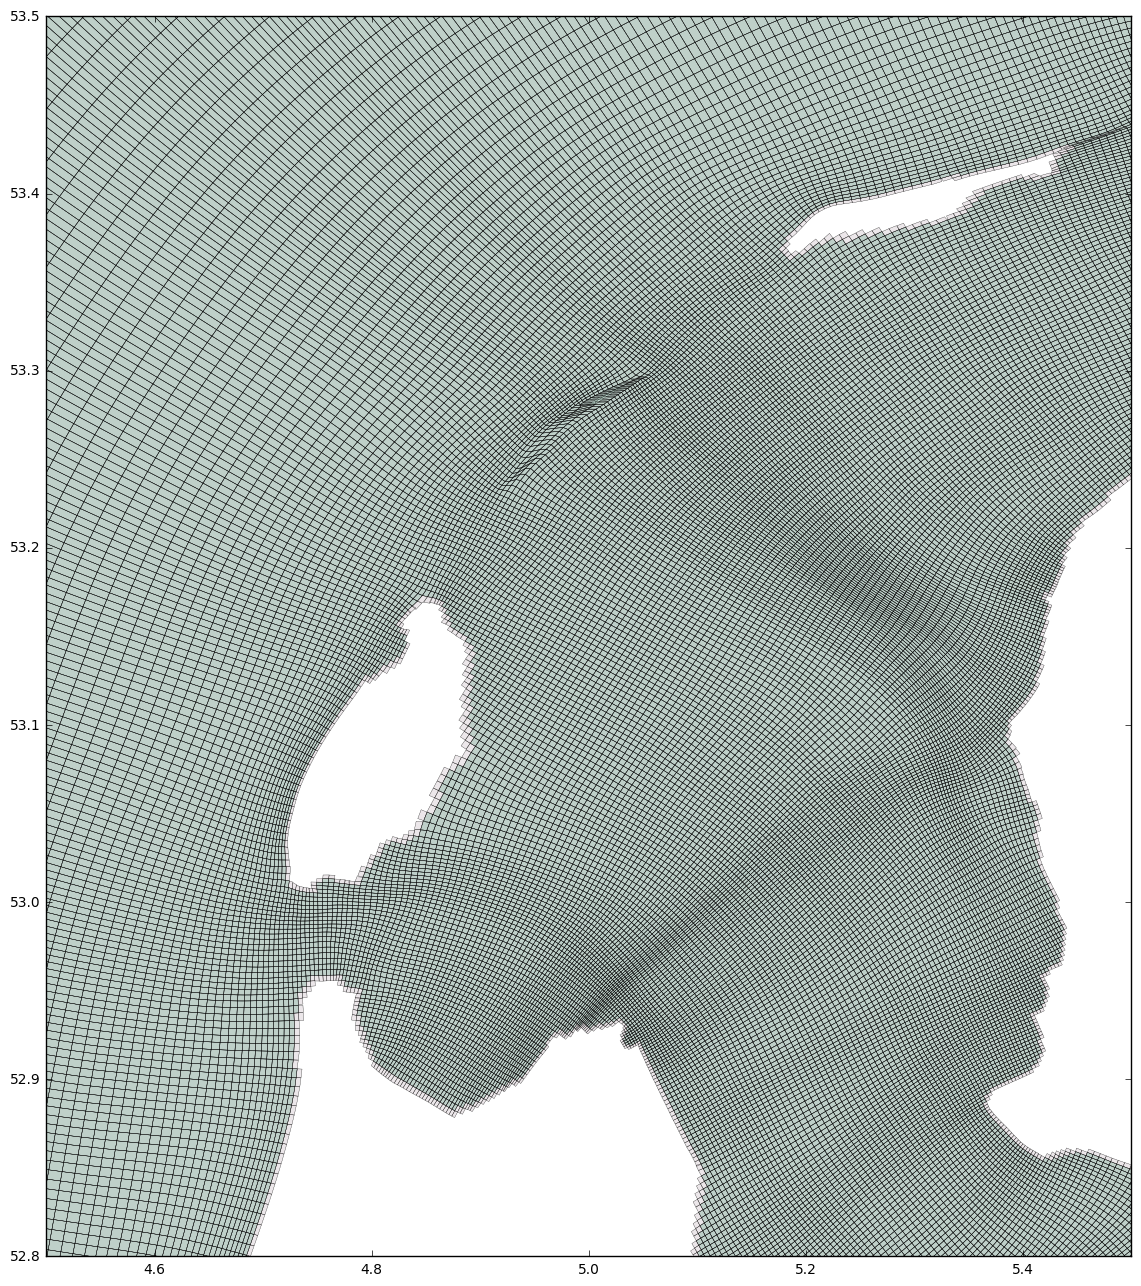

In [28]:
fig, ax = plt.subplots(figsize=(14, 16))
a = np.stack([lon_bounds, lat_bounds], axis=-1)
faces = matplotlib.collections.PolyCollection(
    verts=a[~mask], 
    edgecolor=(0, 0, 0, 0.5), 
    facecolor=(0, 0.5, 0.3, 0.2),
    linewidth=0.3
)
ax.add_collection(faces)
poly = matplotlib.collections.PolyCollection(
    np.array(list(vertices.values())), 
    facecolor=(0.3, 0.1, 0.2, 0.1), 
    linewidth=0.2
)
ax.add_collection(poly)
ax.autoscale()
ax.set_xlim(4.5, 5.5)
ax.set_ylim(52.8, 53.5)
